## Projeto de Machine Learning 

In [2]:
# Imports
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_auc_score, roc_curve, f1_score)
from imblearn.over_sampling import SMOTE
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
caminho_pasta = 'C:/Users/loren/OneDrive/Ambiente de Trabalho/ML'  

# Leitura e concatenação dos dados
arquivos = glob.glob(os.path.join(caminho_pasta, "*.csv"))
df_lista = []
for file in arquivos:
    try:
        df = pd.read_csv(file, encoding='latin-1', sep=';', on_bad_lines='skip', low_memory=False)
        df_lista.append(df)
    except Exception as e:
        print(f"Erro ao ler {file}: {e}")
df = pd.concat(df_lista, ignore_index=True)

In [4]:
#Renomear colunas
colunas_normalizadas = [
    "sigla_icao_empresa_aerea", "empresa_aerea", "numero_voo", "codigo_di", "codigo_tipo_linha",
    "modelo_equipamento", "numero_assentos", "sigla_icao_origem", "descricao_origem",
    "partida_prevista", "partida_real", "sigla_icao_destino", "descricao_destino",
    "chegada_prevista", "chegada_real", "situacao_voo", "justificativa", "referencia",
    "situacao_partida", "situacao_chegada"
]
df.columns = colunas_normalizadas

In [5]:
# Filtrar voos realizados dentro do Brasil, partindo de SP
df = df[df['situacao_voo'] == 'REALIZADO']
df = df[df['descricao_origem'].str.endswith('BRASIL')]
df = df[df['descricao_destino'].str.endswith('BRASIL')]
df = df[df['descricao_origem'].str.contains(r' - SP - ')]

In [6]:
# Converter horários
df['partida_prevista'] = pd.to_datetime(df['partida_prevista'], errors='coerce', dayfirst=True)
df['partida_real'] = pd.to_datetime(df['partida_real'], errors='coerce', dayfirst=True)

In [7]:
# Variável-alvo: atraso maior que 15 min
df['atraso_decolagem'] = ((df['partida_real'] - df['partida_prevista']).dt.total_seconds() / 60 > 15).astype(int)

In [8]:
# Selecionar variáveis
df_model = df[[
    'sigla_icao_empresa_aerea', 'numero_voo', 'codigo_di', 'codigo_tipo_linha',
    'modelo_equipamento', 'numero_assentos', 'sigla_icao_origem', 'sigla_icao_destino',
    'atraso_decolagem'
]].dropna()

In [9]:
# Features e alvo
X = df_model.drop(columns='atraso_decolagem')
y = df_model['atraso_decolagem']

In [10]:
# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

In [11]:
# Padronização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [12]:
# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [13]:
# Balanceamento com SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [14]:
# Ridge (Logística L2)
ridge = LogisticRegression(penalty='l2', solver='liblinear', C=1.0, max_iter=300)
ridge.fit(X_train_res, y_train_res)
y_pred_ridge = ridge.predict(X_test)

In [16]:
# Avaliação do Ridge
print("\n--- Ridge (L2) ---")
print(classification_report(y_test, y_pred_ridge))
print(f"Acurácia: {accuracy_score(y_test, y_pred_ridge):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_ridge):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, ridge.predict_proba(X_test)[:,1]):.4f}")


--- Ridge (L2) ---
              precision    recall  f1-score   support

           0       0.84      0.61      0.70     10480
           1       0.32      0.61      0.42      3143

    accuracy                           0.61     13623
   macro avg       0.58      0.61      0.56     13623
weighted avg       0.72      0.61      0.64     13623

Acurácia: 0.6078
F1-score: 0.4193
AUC-ROC: 0.6535


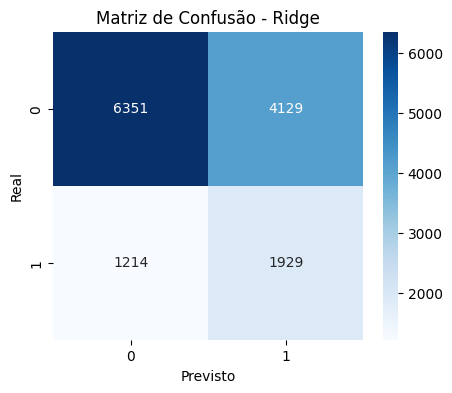

In [17]:
# Matriz de confusão
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_ridge), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Ridge")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

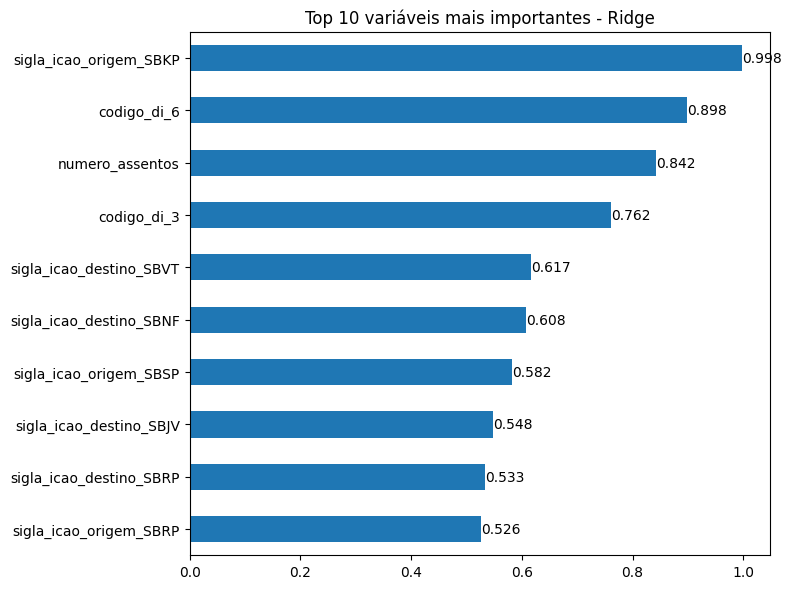

In [18]:
# Importância das variáveis - Ridge
importances = pd.Series(ridge.coef_[0], index=X_encoded.columns)
top10 = importances.abs().sort_values(ascending=False).head(10)

ax = top10.plot(kind='barh', figsize=(8, 6))
plt.title("Top 10 variáveis mais importantes - Ridge")

# Adicionar os rótulos de dados
for i, (value, name) in enumerate(zip(top10.values, top10.index)):
    ax.text(value, i, f'{value:.3f}', va='center', ha='left')

plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()


In [19]:
# Lasso para seleção de variáveis
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=300)
lasso.fit(X_train_res, y_train_res)
sfm = SelectFromModel(lasso, prefit=True)
X_train_sel = sfm.transform(X_train_res)
X_test_sel = sfm.transform(X_test)

In [20]:
# Previsão com Lasso
y_pred_lasso = lasso.predict(X_test)
print("\n--- Lasso ---")
print(classification_report(y_test, y_pred_lasso))
print(f"Acurácia: {accuracy_score(y_test, y_pred_lasso):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_lasso):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, lasso.predict_proba(X_test)[:,1]):.4f}")


--- Lasso ---
              precision    recall  f1-score   support

           0       0.84      0.61      0.70     10480
           1       0.32      0.61      0.42      3143

    accuracy                           0.61     13623
   macro avg       0.58      0.61      0.56     13623
weighted avg       0.72      0.61      0.64     13623

Acurácia: 0.6085
F1-score: 0.4198
AUC-ROC: 0.6539


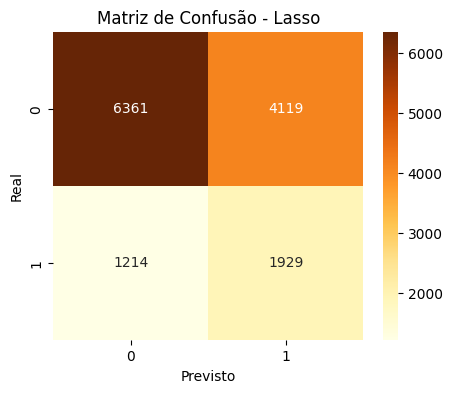

In [21]:
# Matriz de confusão - Lasso
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_lasso), annot=True, fmt="d", cmap="YlOrBr")
plt.title("Matriz de Confusão - Lasso")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

In [22]:
# ElasticNet
elastic = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.001, l1_ratio=0.5, max_iter=300)
elastic.fit(X_train_sel, y_train_res)
y_pred_elastic = elastic.predict(X_test_sel)

In [23]:
print("\n--- ElasticNet ---")
print(classification_report(y_test, y_pred_elastic))
print(f"Acurácia: {accuracy_score(y_test, y_pred_elastic):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_elastic):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, elastic.decision_function(X_test_sel)):.4f}")



--- ElasticNet ---
              precision    recall  f1-score   support

           0       0.83      0.65      0.73     10480
           1       0.32      0.54      0.40      3143

    accuracy                           0.63     13623
   macro avg       0.57      0.60      0.57     13623
weighted avg       0.71      0.63      0.65     13623

Acurácia: 0.6281
F1-score: 0.4027
AUC-ROC: 0.6400


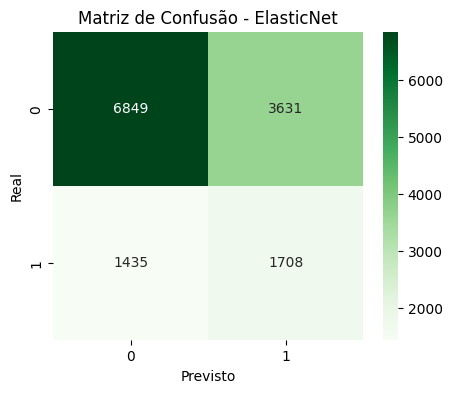

In [24]:
# Matriz de Confusão - ElasticNet
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_elastic), annot=True, fmt="d", cmap="Greens")
plt.title("Matriz de Confusão - ElasticNet")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

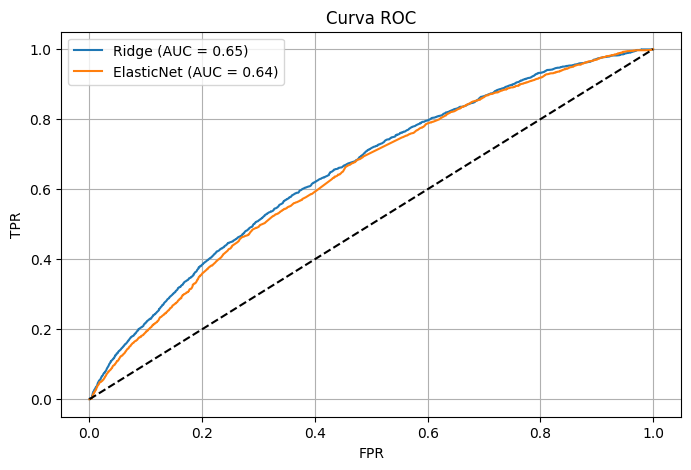

In [25]:
# Curva ROC
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge.predict_proba(X_test)[:,1])
fpr_elastic, tpr_elastic, _ = roc_curve(y_test, elastic.decision_function(X_test_sel))

plt.figure(figsize=(8,5))
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC = {roc_auc_score(y_test, ridge.predict_proba(X_test)[:,1]):.2f})')
plt.plot(fpr_elastic, tpr_elastic, label=f'ElasticNet (AUC = {roc_auc_score(y_test, elastic.decision_function(X_test_sel)):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

In [28]:
# Calcular os AUCs
auc_ridge = roc_auc_score(y_test, y_pred_ridge)
auc_lasso = roc_auc_score(y_test, y_pred_lasso)
auc_elastic = roc_auc_score(y_test, y_pred_elastic)

In [29]:
# Exibir os valores de AUC
print("\n--- AUC dos Modelos ---")
auc_scores = {
    "Ridge (L2)": auc_ridge,
    "Lasso (L1)": auc_lasso,
    "ElasticNet": auc_elastic
}
for nome_modelo, auc in auc_scores.items():
    print(f"{nome_modelo}: {auc:.4f}")

# Comparar sem pressupor qual é o melhor
print("\n--- Melhor Modelo ---")
max_auc = max(auc_scores.values())
melhores = [nome for nome, auc in auc_scores.items() if auc == max_auc]

if len(melhores) == 1:
    print(f"Melhor modelo: {melhores[0]} (AUC = {max_auc:.4f})")
else:
    print(f"Empate entre os modelos: {', '.join(melhores)} (AUC = {max_auc:.4f})")


--- AUC dos Modelos ---
Ridge (L2): 0.6099
Lasso (L1): 0.6104
ElasticNet: 0.5985

--- Melhor Modelo ---
Melhor modelo: Lasso (L1) (AUC = 0.6104)


In [30]:
modelo_final = {
    'modelo': lasso,  
    'colunas': X_encoded.columns.tolist(),
    'resultados': { 'auc': auc_ridge } 
}
import pickle
with open('modelo_final.pkl', 'wb') as f:
    pickle.dump(modelo_final, f)

In [31]:
# Salvar o scaler usado
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']